In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os



import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)

In [ ]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [4]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [5]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('jet_px = jet_pt*cos(jet_phi)', inplace=True)
    temp.eval('jet_py = jet_pt*sin(jet_phi)', inplace=True)
    temp.eval('jet_qt = sqrt( (jet_px + e_px)**2 + (jet_py + e_py)**2) ', inplace=True)
    temp.eval('jet_qtnorm = jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)
    temp.eval('jet_phi = arctan(jet_py/jet_px)',inplace=True)
    temp.eval('jet_dphi = e_phi-jet_phi',inplace=True)
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)

    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt>10.0', 'jet pT > 10 GeV')


    if(isMC):
        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        temp.eval('genjet_px = genjet_pt*cos(genjet_phi)', inplace=True)
        temp.eval('genjet_py = genjet_pt*sin(genjet_phi)', inplace=True)
        temp.eval('genjet_qt = sqrt( (genjet_px + gene_px)**2 + (genjet_py + gene_py)**2) ', inplace=True)
        temp.eval('genjet_qtnorm = genjet_qt/sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_phi = arctan(gene_py/gene_px)', inplace=True)
        temp.eval('genjet_phi = arctan(genjet_py/genjet_px)',inplace=True)
        temp.eval('genjet_dphi = gene_phi-genjet_phi',inplace=True)
        
    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [6]:
path = '/home/miguel/HERA/out_em0405/'
#path = '/home/miguel/HERA/out_ep0607/'
dataname = path+'data.root'
mcname = path+'Django.root'
altmcname = path+'Rapgap.root'

In [7]:
datatree = uproot3.open(dataname)['Data/minitree']
mctree   = uproot3.open(mcname)['Django/minitree']
altmctree  = uproot3.open(altmcname)['Rapgap/minitree']

In [8]:
data =  datatree.pandas.df(["jet*","Q2","y","e_*"], entrystop=3e5,flatten=True)   # not the default

In [9]:
mc =  mctree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y",'gen_y',"e_*","gene*"], entrystop=3e5,flatten=True)   # not the default

In [10]:
altmc =  altmctree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y","gen_y","e_*","gene*"], entrystop=3e5,flatten=True)   # not the default

In [11]:
mc.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'genjet_pt', 'genjet_phi',
       'genjet_eta', 'Q2', 'gen_Q2', 'y', 'gen_y', 'e_px', 'e_py', 'e_pz',
       'gene_px', 'gene_py', 'gene_pz'],
      dtype='object')

## Defining pass reco and pass truth variables

In [12]:
mc['pass_reco'] = np.where(mc['jet_pt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['jet_pt']>0, 1, 0)
altmc['pass_reco'] = np.where(altmc['jet_pt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['jet_pt']>0, 1, 0)
data['pass_reco'] = np.where(data['jet_pt']>0, 1, 0)

## Event selection

In [13]:
print('Selecting data events\n')
data = applyCutsJets(data)
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('alt mc')
altmc = applyCutsJets(altmc, isMC=True)

Selecting data events

0.2 < y < 0.7 126239  fraction kept: 53.6
Q2>150 105569  fraction kept: 83.6
jet pT > 10 GeV 80332  fraction kept: 76.1
Selecting MC events

0.2 < y < 0.7 222043  fraction kept: 69.6
Q2>150 190202  fraction kept: 85.7
jet pT > 10 GeV 153475  fraction kept: 80.7
alt mc
0.2 < y < 0.7 213671  fraction kept: 69.0
Q2>150 187438  fraction kept: 87.7
jet pT > 10 GeV 149981  fraction kept: 80.0


In [14]:
mc.head()

jet_pt   jet_phi   jet_eta  jet_dphi  genjet_pt  \
entry subentry                                                       
0     0         17.821012  1.130563 -0.132420 -0.000610  18.245798   
2     0         19.339769 -1.484573 -0.498900 -0.030946  18.930017   
4     0         14.035999  0.785462  0.309769  0.066127  14.487093   
5     0         17.071587 -1.535646  0.296118  2.518459  18.760893   
      1         10.083800 -0.111875  2.238095  1.094688  11.687999   

                genjet_phi  genjet_eta          Q2      gen_Q2         y  ...  \
entry subentry                                                            ...   
0     0           1.105824   -0.101553  503.772125  493.079468  0.386226  ...   
2     0          -1.465013   -0.514370  842.442139  878.726135  0.655872  ...   
4     0           0.795348    0.279637  368.373474  352.494873  0.223028  ...   
5     0          -1.564107    0.225322  745.689453  726.796326  0.365576  ...   
      1          -0.114535    2.183209  745.689453  726.796326  0.365576  ...   

                   e_phi     logQ2  gen_logQ2    gene_pt  genjet_px  \
entry subentry                                                        
0     0         1.129953  2.702235   2.692917  17.102211  -8.181376   
2     0        -1.515518  2.925540   2.943854  17.760504  -1.998747   
4     0         0.851590  2.566288   2.547153  16.473866  10.141495   
5     0         0.982813  2.872558   2.861413  21.004848   0.125492   
      1         0.982813  2.872558   2.861413  21.004848 -11.611420   

                genjet_py  genjet_qt  genjet_qtnorm  gene_phi  genjet_dphi  
entry subentry                                                              
0     0        -16.308718   1.224973       0.055166  1.130679     0.024855  
2     0         18.824202   1.494112       0.050403 -1.515730    -0.050717  
4     0         10.345334   2.160768       0.115088  0.850343     0.054996  
5     0        -18.760473  11.833632       0.438947  0.983490     2.547597  
      1          1.335757  18.820978       0.698129  0.983490     1.098025  

[5 rows x 34 columns]

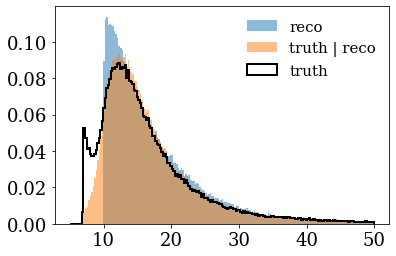

In [28]:
#plt.hist(mc.query('pass_reco==1')['e_pt'],range=(0,50),bins=200,**plot_style_2)
plt.hist(mc.query('pass_reco==1')['jet_pt'],range=(5,50),bins=200,**plot_style_2,label='reco')
plt.hist(mc.query('pass_reco==1')['genjet_pt'],range=(5,50),bins=200,**plot_style_2, label='truth | reco')
plt.hist(mc['genjet_pt'],range=(5,50),bins=200,**plot_style_1, label='truth')
plt.legend(loc='best')
plt.show()

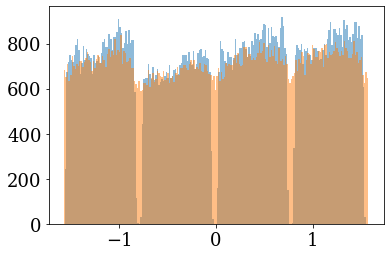

In [29]:
plt.hist(mc.query('pass_reco==1')['e_phi'],bins=200,alpha=0.5)
plt.hist(mc.query('pass_reco==1')['jet_phi'],bins=200,alpha=0.5)

#plt.hist(mc.query('pass_reco==1')['jet_phi'],bins=200,alpha=0.5)

plt.show()

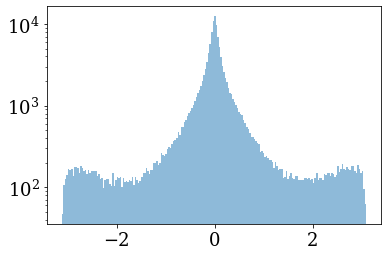

In [30]:
plt.hist(mc.query('pass_reco==1')['jet_dphi'],bins=200,alpha=0.5)
plt.yscale('log')
plt.show()



In [32]:
mc_cut = mc#[:100000]
altmc_cut = altmc#[:100000]

In [33]:
print(len(data))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts
print(len(altmc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts


80332
142383
153475
138347


### Define UniFold Algorithm


In [34]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

## Define features using just MC and alt MC *this is CLOSURE TEST*

In [35]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_G = altmc_cut['gene_px']
epx_unknown_S = altmc_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_G = altmc_cut['gene_py']
epy_unknown_S = altmc_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_G = altmc_cut['gene_pz']
epz_unknown_S = altmc_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_G = altmc_cut['genjet_pt']
jetpt_unknown_S = altmc_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_G = altmc_cut['genjet_phi']
jetphi_unknown_S = altmc_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_G = altmc_cut['genjet_eta']
jeteta_unknown_S = altmc_cut['jet_eta']


jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']
jetdphi_unknown_G = altmc_cut['genjet_dphi']
jetdphi_unknown_S = altmc_cut['jet_dphi']


jetqt_0_G       = mc_cut['genjet_qtnorm']
jetqt_0_S       = mc_cut['jet_qtnorm']
jetqt_unknown_G = altmc_cut['genjet_qtnorm']
jetqt_unknown_S = altmc_cut['jet_qtnorm']


In [36]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S)]
theta_unknown_G =np.c_[(epx_unknown_G, epy_unknown_G, epz_unknown_G, jetpt_unknown_G, jeteta_unknown_G, jetphi_unknown_G, jetdphi_unknown_G, jetqt_unknown_G)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S)]


In [37]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


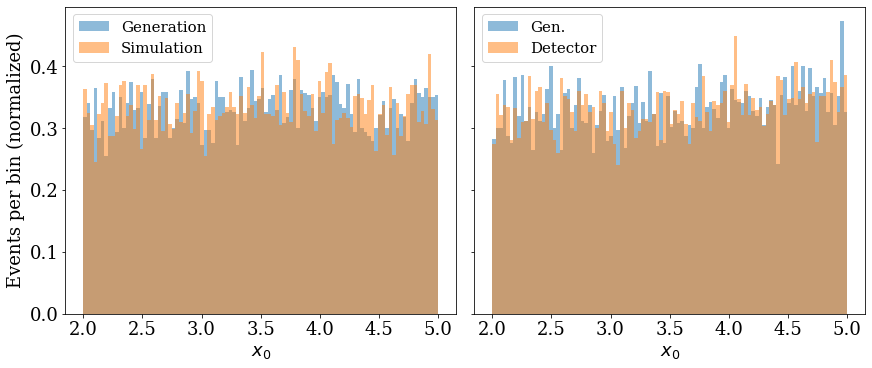

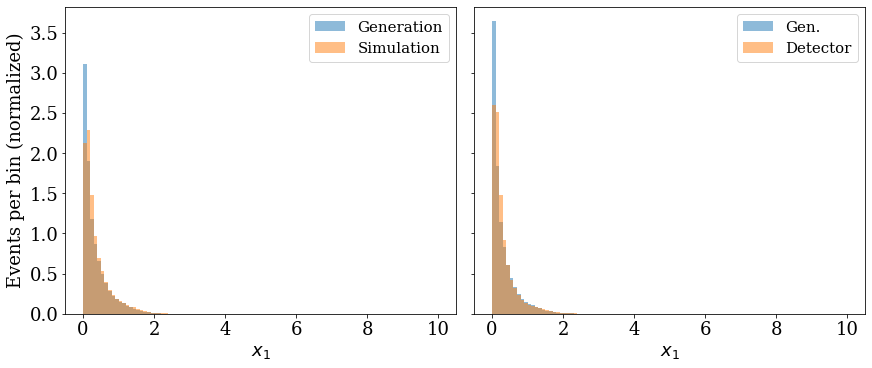

In [38]:
bins = np.linspace(2,5, 101)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)


ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

bins = np.linspace(0,10, 101)
#bins = np.linspace(0,2, 101)
#bins = np.linspace(0,1,100)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)

ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)






plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Define Multifold 

In [39]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    

    weights = np.empty(shape=(iterations, 2, len(theta0_G))) #this was 0
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))

    inputs = Input((num_observables, ))
     #inputs = Input((2, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data (not MC weights)

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        #theta0_G[theta0_S[:,0]!=-10][:,1]
        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_1[X_train_1[:,0]!=-10],
              Y_train_1[X_train_1[:,0]!=-10],
              sample_weight=w_train_1[X_train_1[:,0]!=-10],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1[:,0]!=-10], Y_test_1[X_test_1[:,0]!=-10], w_test_1[X_test_1[:,0]!=-10]),
              callbacks=[earlystopping],
              verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1. #these are events that don't pass reco; take the prior.
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_push
    return weights, model

## Unfold two variables simultaneously

In [40]:
K.clear_session()

In [41]:
iterations = 4# use ~4 iterations
num_observables= 8

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S)


ITERATION: 1

STEP 1

Epoch 1/200
22/22 [==============================] - 8s 358ms/step - loss: 1.1168 - accuracy: 0.5156 - val_loss: 0.6851 - val_accuracy: 0.5198
Epoch 2/200
22/22 [==============================] - 0s 7ms/step - loss: 0.6751 - accuracy: 0.5266 - val_loss: 0.6699 - val_accuracy: 0.5280
Epoch 3/200
22/22 [==============================] - 0s 7ms/step - loss: 0.6686 - accuracy: 0.5310 - val_loss: 0.6671 - val_accuracy: 0.5318
Epoch 4/200
22/22 [==============================] - 0s 7ms/step - loss: 0.6668 - accuracy: 0.5348 - val_loss: 0.6656 - val_accuracy: 0.5379
Epoch 5/200
22/22 [==============================] - 0s 9ms/step - loss: 0.6659 - accuracy: 0.5380 - val_loss: 0.6650 - val_accuracy: 0.5439
Epoch 6/200
22/22 [==============================] - 0s 8ms/step - loss: 0.6653 - accuracy: 0.5410 - val_loss: 0.6645 - val_accuracy: 0.5448
Epoch 7/200
22/22 [==============================] - 0s 7ms/step - loss: 0.6647 - accuracy: 0.5428 - val_loss: 0.6644 - val_accur

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/200
24/24 [==============================] - 8s 328ms/step - loss: 0.6853 - accuracy: 0.4999 - val_loss: 0.6827 - val_accuracy: 0.5012
Epoch 2/200
24/24 [==============================] - 0s 7ms/step - loss: 0.6832 - accuracy: 0.5001 - val_loss: 0.6827 - val_accuracy: 0.5003
Epoch 3/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6828 - accuracy: 0.4992 - val_loss: 0.6896 - val_accuracy: 0.4992
Epoch 4/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6845 - accuracy: 0.4990 - val_loss: 0.6839 - val_accuracy: 0.4984
Epoch 5/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6831 - accuracy: 0.4998 - val_loss: 0.6925 - val_accuracy: 0.5014
Epoch 6/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6868 - accuracy: 0.4995 - val_loss: 0.6831 - val_accuracy: 0.4988
Epoch 7/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6825 - accuracy: 0.5002 - val_loss: 0.6831 - val_accuracy: 0.5000
Epoch 8/200

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply


Epoch 1/200
24/24 [==============================] - 7s 290ms/step - loss: 0.6810 - accuracy: 0.4992 - val_loss: 0.6789 - val_accuracy: 0.4991
Epoch 2/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6792 - accuracy: 0.4993 - val_loss: 0.6790 - val_accuracy: 0.4986
Epoch 3/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6791 - accuracy: 0.5003 - val_loss: 0.6798 - val_accuracy: 0.5030
Epoch 4/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6799 - accuracy: 0.5005 - val_loss: 0.6797 - val_accuracy: 0.4983
Epoch 5/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6795 - accuracy: 0.5003 - val_loss: 0.6799 - val_accuracy: 0.4979
Epoch 6/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6800 - accuracy: 0.4990 - val_loss: 0.6811 - val_accuracy: 0.4979
Epoch 7/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6797 - accuracy: 0.4995 - val_loss: 0.6841 - val_accuracy: 0.4978
Epoch 8/200

24/24 [==============================] - 0s 6ms/step - loss: 0.6779 - accuracy: 0.4999 - val_loss: 0.6780 - val_accuracy: 0.4983
Epoch 7/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6773 - accuracy: 0.4998 - val_loss: 0.6771 - val_accuracy: 0.4993
Epoch 8/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6773 - accuracy: 0.4995 - val_loss: 0.6787 - val_accuracy: 0.4996
Epoch 9/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6779 - accuracy: 0.5002 - val_loss: 0.6776 - val_accuracy: 0.5007
Epoch 10/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6775 - accuracy: 0.4998 - val_loss: 0.6773 - val_accuracy: 0.4989
Epoch 11/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6777 - accuracy: 0.5007 - val_loss: 0.6779 - val_accuracy: 0.4995
Epoch 12/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6771 - accuracy: 0.4992 - val_loss: 0.6832 - val_accuracy: 0.4986
Epoch 13/200
24/24 [==

## Put weights into MC dataframe

In [42]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

## Check that weights are reasonable

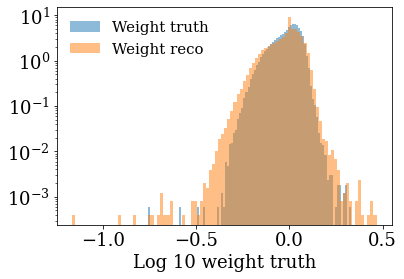

2.436685085296631
0.15146848559379578
3.246577262878418
0.19247348606586456
 
2.2579946517944336
0.20933592319488525
5.162096977233887
0.09830139577388763
 
4.259862899780273
0.23705963790416718
4.203189849853516
0.054967716336250305
 
2.1376266479492188
0.17503930628299713
2.9367904663085938
0.06841568648815155
 


In [43]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Remove some large weights 

In [44]:
print(len(mc_cut))
mc_cut.query('weight_truth>10000')
print(len(mc_cut.query(' weight_reco>0.01')))

mc_cut = mc_cut.query('weight_reco<100 and weight_reco>0.01')
#altmc_cut = altmc_cut.query('weight_truth<10000')
print(len(mc_cut))

mc_cut = mc_cut.query('weight_truth<100 and weight_truth>0.01')
print(len(mc_cut))

153475
153475
153475
153475


## Closure Test

The query is: pass_reco==1 and gen_y>0.2 and gen_y<0.7 and gen_Q2>150 and genjet_pt>15
ITERATION: 3
ITERATION: 4


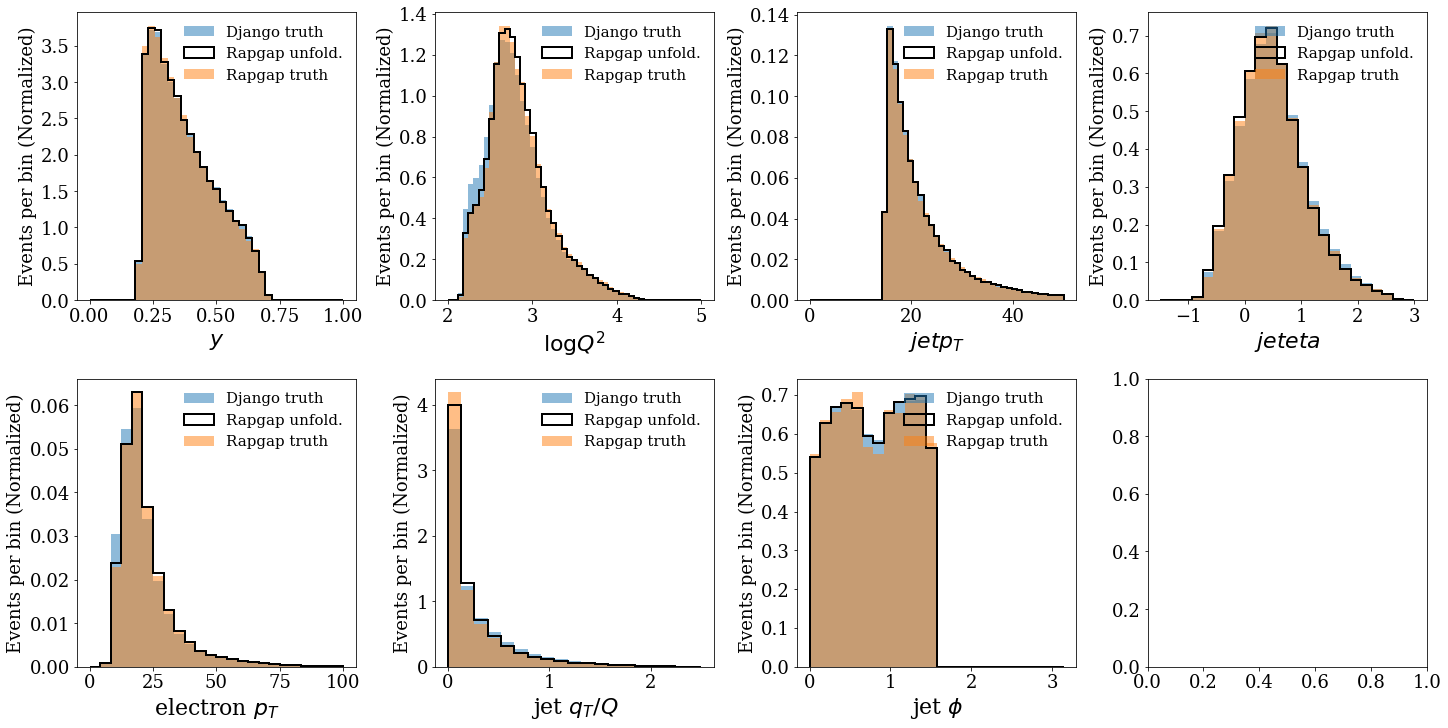

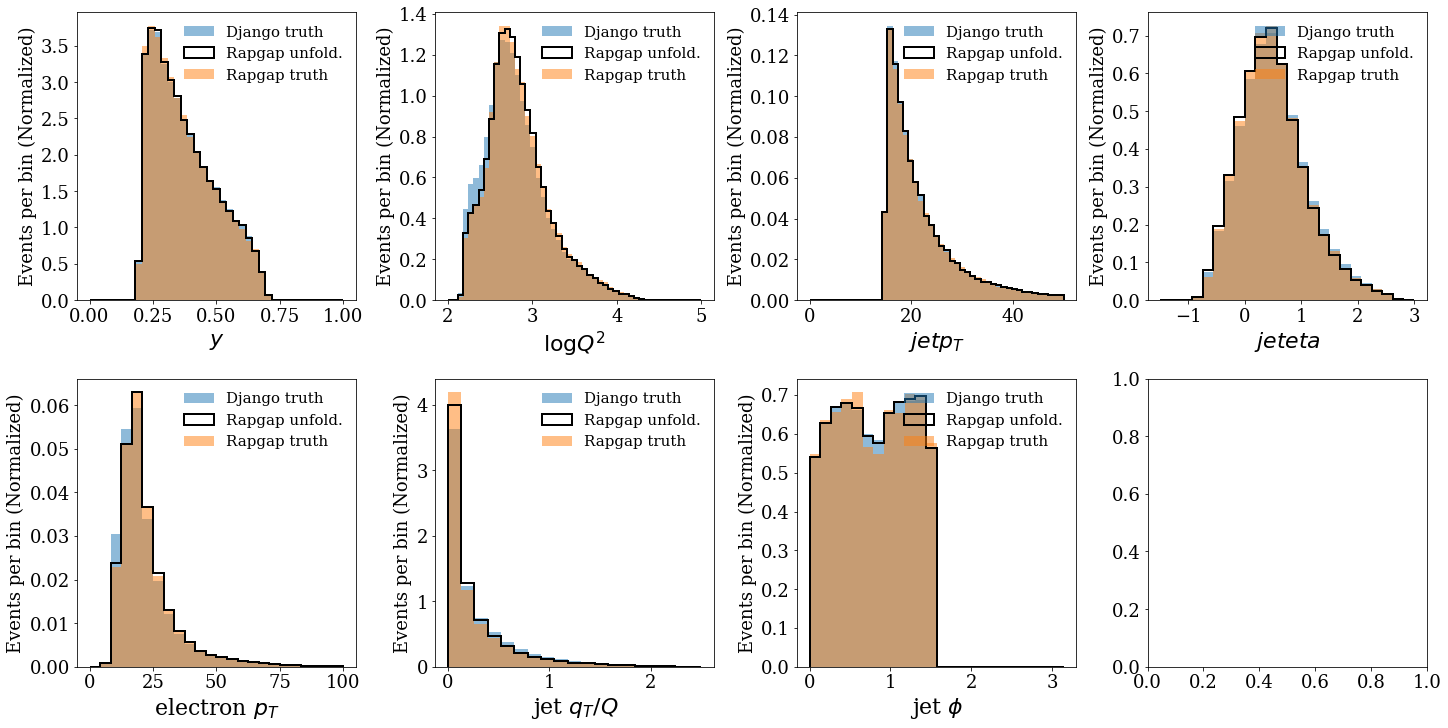

In [59]:
event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
#track_selection = 'gen_track_pt>0.2'
jet_selection    = 'genjet_pt>15'
query = 'pass_reco==1 and ' + event_selection + ' and ' + jet_selection
print('The query is:' , query)

label1 = r'Django truth'
label2 = r'Rapgap unfold.'
label3 = r'Rapgap truth'


for i in range(len(weights)):
    if(i<2): continue
    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0,0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(altmc_cut.query(query)['gen_y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,0].legend(frameon=False)

    bins = np.linspace(2, 5,50 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(altmc_cut.query(query)['gen_logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,1].legend(frameon=False)

    

    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'], bins=bins, label=label1, **plot_style_2)
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(altmc_cut.query(query)['genjet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,2].legend(frameon=False)


    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'], bins=bins, label=label1, **plot_style_2)
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(altmc_cut.query(query)['genjet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,3].legend(frameon=False)

    bins = np.linspace(0,100,25)

    ax[1,0].set_xlabel(r'electron $p_{T}$',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[1,0].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(altmc_cut.query(query)['gene_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[1,0].legend(frameon=False,loc='best')
    
    
    
    bins = np.linspace(0,2.5,20)

    ax[1,1].set_xlabel(r'jet $q_{T}/Q$',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['genjet_qtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[1,1].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(altmc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[1,1].legend(frameon=False,loc='best')
    
    
    
    bins = np.linspace(0,np.pi,25)

    ax[1,2].set_xlabel(r'jet $\phi$',fontsize=22)
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(mc_cut.query(query)['genjet_phi'], bins=bins, label=label1, **plot_style_2)
    ax[1,2].hist(mc_cut.query(query)['genjet_phi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,2].hist(altmc_cut.query(query)['genjet_phi'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[1,2].legend(frameon=False,loc='best')
    


    #fig.savefig('figures/Closure_HadronInJet_%i_iter.png'%i)    

## Show the reweighting of the reco

The query is: pass_reco==1 
ITERATION: 3
ITERATION: 4


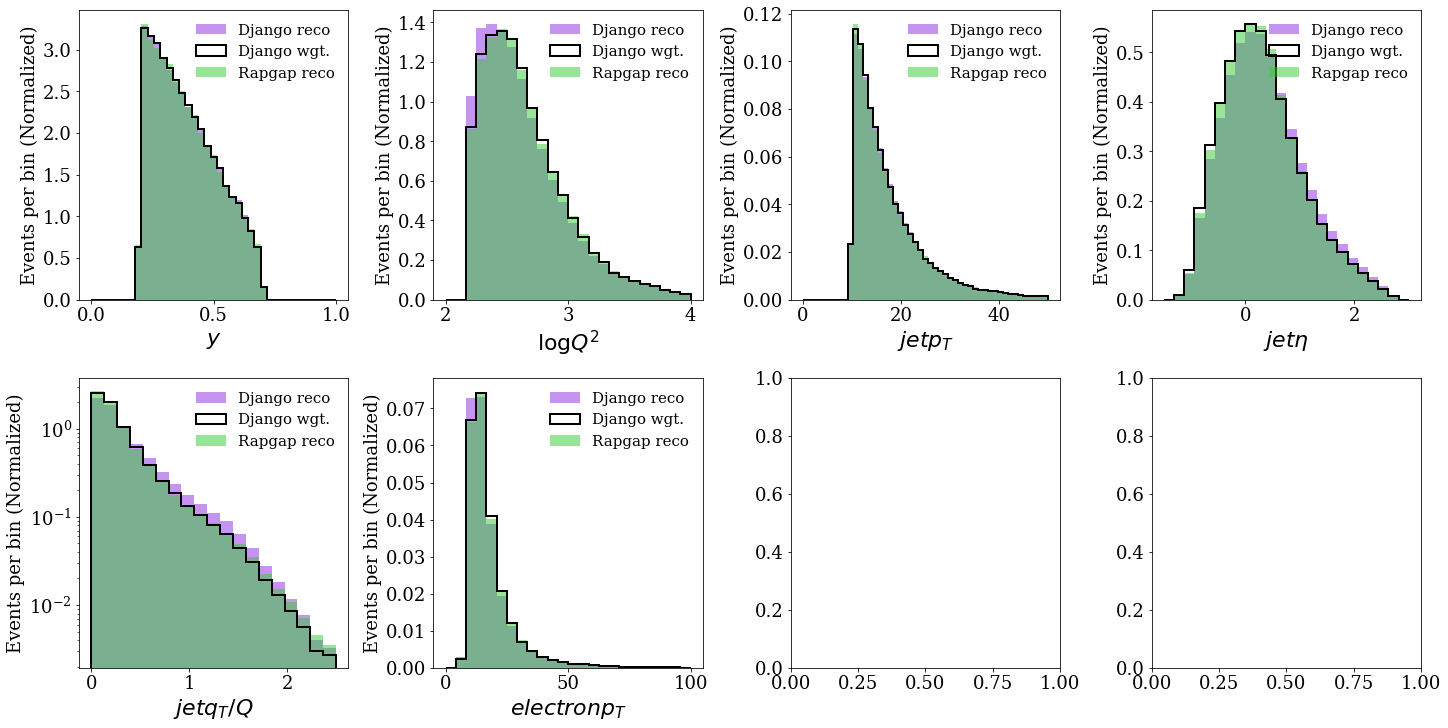

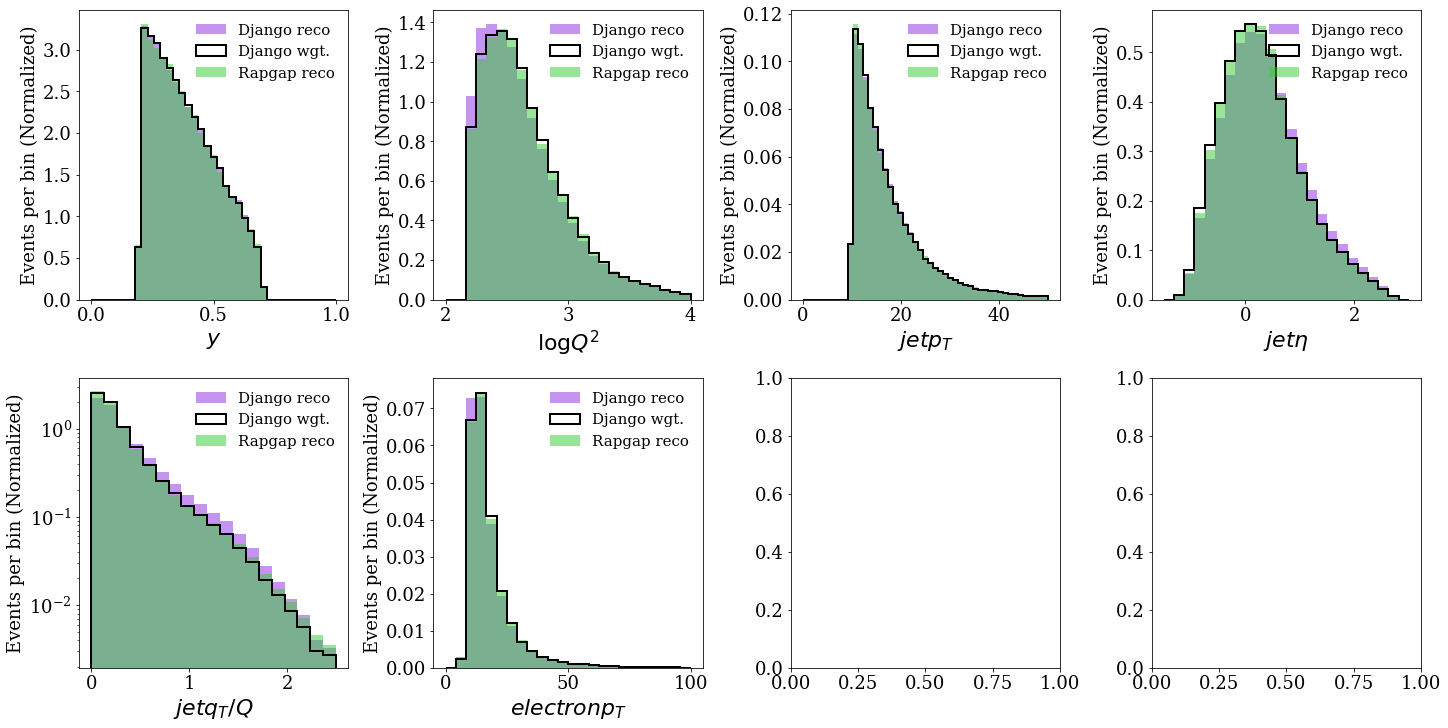

In [60]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = r'Django reco'
label2 = r'Django wgt.'
label3 = r'Rapgap reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):
    if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(altmc_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(altmc_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,1].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$ jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['jet_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(altmc_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[0,2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet \eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['jet_eta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(altmc_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[0,3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,20)
    
    ax[1,0].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(altmc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1,0].legend(frameon=False,loc='best')
    ax[1,0].set_yscale('log')

   
    bins = np.linspace(0,100,25)

    ax[1,1].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,1].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(altmc_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[1,1].legend(frameon=False,loc='best')
    
    #plt.tight_layout()
    #fig.savefig('figures/Closure_3_HadronInJet_%i_iter.png'%i)  
    
    

## Closure for differential plots

 gen_Q2 > 150.00 and gen_Q2 <500.00 and gen_y>0.2 and gen_y<0.7 and genjet_pt>15
###########
 gen_Q2 > 500.00 and gen_Q2 <1000.00 and gen_y>0.2 and gen_y<0.7 and genjet_pt>15
###########
 gen_Q2 > 1000.00 and gen_Q2 <10000.00 and gen_y>0.2 and gen_y<0.7 and genjet_pt>15
###########


Text(0, 0.5, 'Normalized entries')

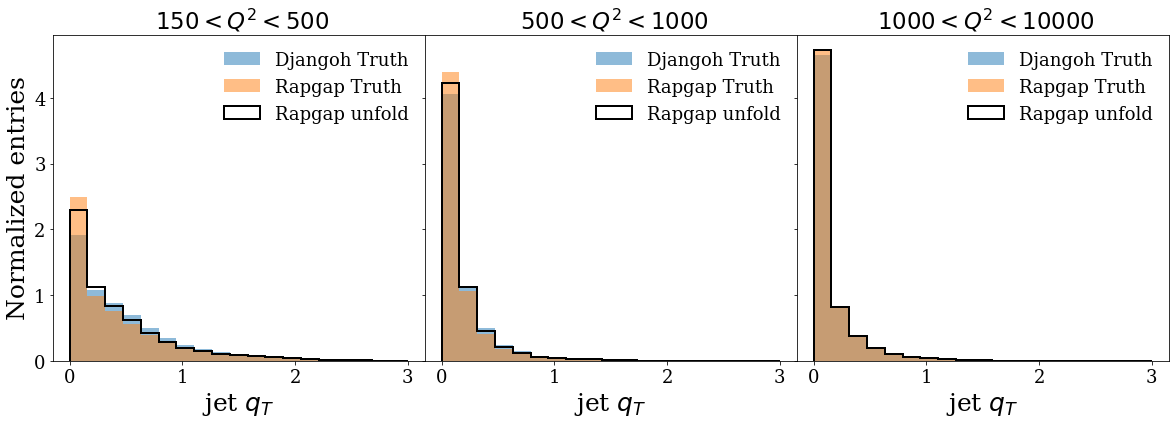

In [61]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.linspace(0,3,20)

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f and gen_y>0.2 and gen_y<0.7'%(edges[0],edges[1])
    cut = cut + ' and genjet_pt>15'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
   # axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['track_jt'],weights=mc_cut.query(cut+'and pass_reco==1')['weight_reco'],bins=bins,alpha=0.9,density=True, 
   #                  label='MC wgt to data reco',color='blue',lw=3,histtype='step')

    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['gen_track_jt'],bins=bins,weights=mc_cut.query(cut+'and pass_reco==1')['weight_truth'],label = 'Unfolded',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Djangoh Truth',**plot_style_2)
    axs[counter].hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Rapgap Truth',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


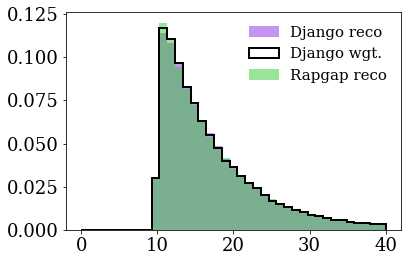

In [62]:
bins = np.linspace(0,40,40 )
query = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'

#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

plt.hist(altmc_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
plt.legend(frameon=False,loc='best')

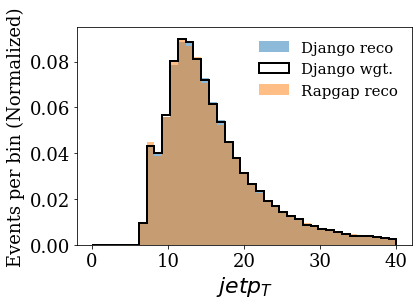

In [63]:
query = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'

plt.hist(mc_cut.query(query)['genjet_pt'], bins=bins, label=label1, **plot_style_2)
plt.hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

plt.hist(altmc_cut.query(query)['genjet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)

plt.xlabel(r'$jet p_{T} $',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
plt.legend(frameon=False)

## Closure Test  jet pT spectrum

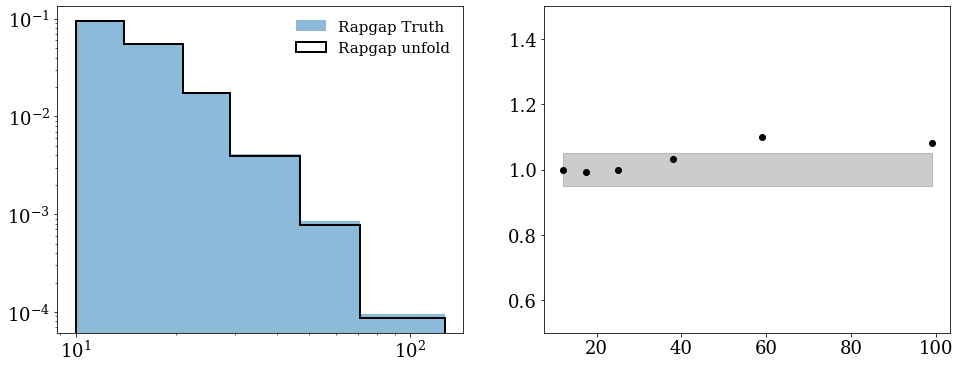

In [77]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
#bins = np.logspace(np.log10(15),np.log10(100),8)
bins = np.array([10,14,21,29,47,71,127])

#ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label='Django Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label='Rapgap Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xscale('log')


ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

plt.show()

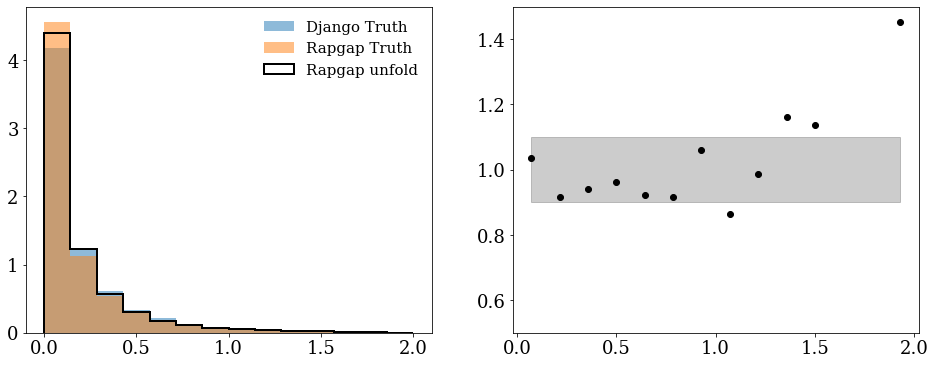

In [71]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 300 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>15'
bins = np.linspace(0,2,15)
ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Django Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Rapgap Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')


ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.9,1.1,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

plt.show()

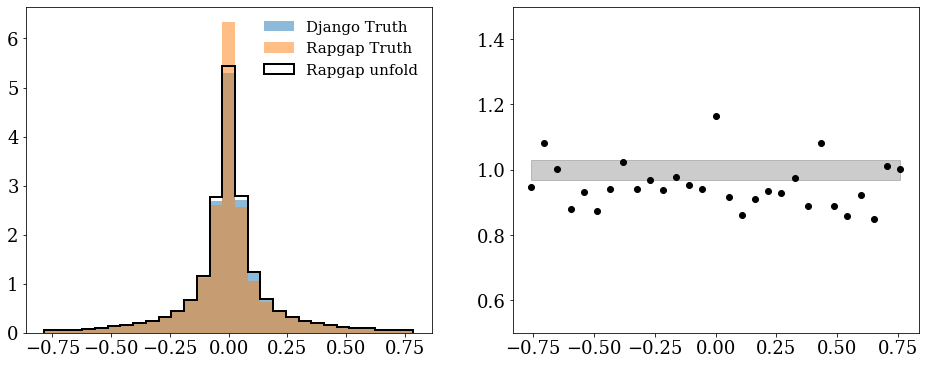

In [72]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 300 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>15'
bins = np.linspace(-np.pi/4.0,np.pi/4.0,30) 
ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,label='Django Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_dphi'],bins=bins,label='Rapgap Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')


ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.97,1.03,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

plt.show()

## check weights

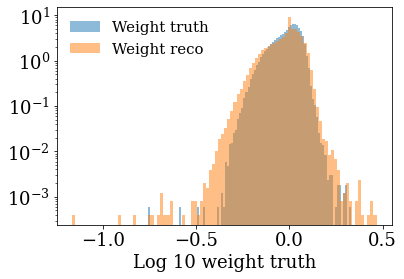

2.436685085296631
0.15146848559379578
3.246577262878418
0.19247348606586456
 
2.2579946517944336
0.20933592319488525
5.162096977233887
0.09830139577388763
 
4.259862899780273
0.23705963790416718
4.203189849853516
0.054967716336250305
 
2.1376266479492188
0.17503930628299713
2.9367904663085938
0.06841568648815155
 


In [73]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Compute some efficiency

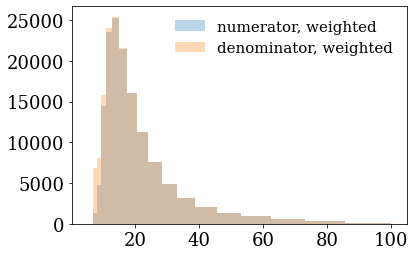

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [74]:
bins = np.logspace(np.log10(5),np.log10(100),20)
num,x,_  = plt.hist(mc_cut.query('pass_reco==1')['genjet_pt'], weights=mc_cut.query('pass_reco==1')['weight_truth'],bins=bins,label='numerator, weighted',alpha=0.3)
den,x,_  = plt.hist(mc_cut['genjet_pt'], weights=mc_cut['weight_truth'],bins=bins,label='denominator, weighted',alpha=0.3)
x= (x[1:] + x[:-1])/2.0

plt.legend()
plt.show()
eff_weighted= np.true_divide(num,den)

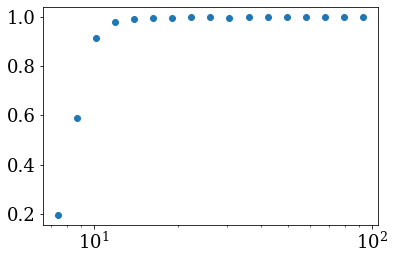

In [75]:
plt.plot(x,eff_weighted,'o')
plt.xscale('log')

In [57]:
K.clear_session()

## Define features with data

In [78]:
mc_cut = mc[:1000000]
altmc_cut = altmc[:1000000]
data_cut = data[:50000]

print(len(mc_cut))
print(len(data_cut))

153475
50000


In [79]:
mc_cut = pd.concat([mc_cut, altmc_cut])

In [80]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


50000
280730
303456


In [81]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_S = data_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_S = data_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_S = data_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_S = data_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_S = data_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_S = data_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']
jetdphi_unknown_S = data_cut['jet_dphi']


jetqt_0_G       = mc_cut['genjet_qtnorm']
jetqt_0_S       = mc_cut['jet_qtnorm']
jetqt_unknown_S = data_cut['jet_qtnorm']



In [82]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S)]
theta_unknown_G =np.c_[(epx_unknown_G, epy_unknown_G, epz_unknown_G, jetpt_unknown_G, jeteta_unknown_G, jetphi_unknown_G, jetdphi_unknown_G, jetqt_unknown_G)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S)]


In [83]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

In [84]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


50000
280730
303456


## Run unfolding on data

In [85]:
K.clear_session()

In [86]:
iterations = 4# use ~4 iterations
num_observables= 8

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S)


ITERATION: 1

STEP 1

Epoch 1/200
25/25 [==============================] - 8s 338ms/step - loss: 0.8686 - accuracy: 0.6885 - val_loss: 0.5039 - val_accuracy: 0.8476
Epoch 2/200
25/25 [==============================] - 0s 7ms/step - loss: 0.4586 - accuracy: 0.8490 - val_loss: 0.4467 - val_accuracy: 0.8475
Epoch 3/200
25/25 [==============================] - 0s 7ms/step - loss: 0.4407 - accuracy: 0.8492 - val_loss: 0.4415 - val_accuracy: 0.8475
Epoch 4/200
25/25 [==============================] - 0s 7ms/step - loss: 0.4372 - accuracy: 0.8492 - val_loss: 0.4390 - val_accuracy: 0.8476
Epoch 5/200
25/25 [==============================] - 0s 7ms/step - loss: 0.4351 - accuracy: 0.8492 - val_loss: 0.4372 - val_accuracy: 0.8476
Epoch 6/200
25/25 [==============================] - 0s 7ms/step - loss: 0.4335 - accuracy: 0.8492 - val_loss: 0.4358 - val_accuracy: 0.8476
Epoch 7/200
25/25 [==============================] - 0s 7ms/step - loss: 0.4323 - accuracy: 0.8492 - val_loss: 0.4346 - val_accur

25/25 [==============================] - 0s 7ms/step - loss: 0.4179 - accuracy: 0.8493 - val_loss: 0.4215 - val_accuracy: 0.8476
Epoch 59/200
25/25 [==============================] - 0s 6ms/step - loss: 0.4177 - accuracy: 0.8492 - val_loss: 0.4223 - val_accuracy: 0.8476
Epoch 60/200
25/25 [==============================] - 0s 7ms/step - loss: 0.4179 - accuracy: 0.8492 - val_loss: 0.4217 - val_accuracy: 0.8476
Epoch 61/200
25/25 [==============================] - 0s 6ms/step - loss: 0.4178 - accuracy: 0.8492 - val_loss: 0.4218 - val_accuracy: 0.8476
Epoch 62/200
25/25 [==============================] - 0s 6ms/step - loss: 0.4177 - accuracy: 0.8492 - val_loss: 0.4217 - val_accuracy: 0.8476
Epoch 63/200
25/25 [==============================] - 0s 6ms/step - loss: 0.4176 - accuracy: 0.8492 - val_loss: 0.4215 - val_accuracy: 0.8476
Epoch 64/200
25/25 [==============================] - 0s 6ms/step - loss: 0.4176 - accuracy: 0.8492 - val_loss: 0.4222 - val_accuracy: 0.8476
Epoch 65/200
25/25 

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/200
46/46 [==============================] - 15s 335ms/step - loss: 0.2901 - accuracy: 0.5003 - val_loss: 0.2869 - val_accuracy: 0.4989
Epoch 2/200
46/46 [==============================] - 0s 7ms/step - loss: 0.2865 - accuracy: 0.5004 - val_loss: 0.2860 - val_accuracy: 0.4987
Epoch 3/200
46/46 [==============================] - 0s 8ms/step - loss: 0.2857 - accuracy: 0.5005 - val_loss: 0.2855 - val_accuracy: 0.4986
Epoch 4/200
46/46 [==============================] - 0s 7ms/step - loss: 0.2852 - accuracy: 0.5004 - val_loss: 0.2847 - val_accuracy: 0.4987
Epoch 5/200
46/46 [==============================] - 0s 9ms/step - loss: 0.2848 - accuracy: 0.5003 - val_loss: 0.2845 - val_accuracy: 0.4986
Epoch 6/200
46/46 [==============================] - 0s 7ms/step - loss: 0.2845 - accuracy: 0.5003 - val_loss: 0.2843 - val_accuracy: 0.4986
Epoch 7/200
46/46 [==============================] - 0s 8ms/step - loss: 0.2842 - accuracy: 0.5003 - val_loss: 0.2839 - val_accuracy: 0.4985
Epoch 8/20

Epoch 59/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2814 - accuracy: 0.5007 - val_loss: 0.2821 - val_accuracy: 0.4978
Epoch 60/200
46/46 [==============================] - 0s 7ms/step - loss: 0.2813 - accuracy: 0.5006 - val_loss: 0.2816 - val_accuracy: 0.4980
Epoch 61/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2813 - accuracy: 0.5006 - val_loss: 0.2817 - val_accuracy: 0.4981
Epoch 62/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2813 - accuracy: 0.5010 - val_loss: 0.2820 - val_accuracy: 0.4982
Epoch 63/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2813 - accuracy: 0.5006 - val_loss: 0.2816 - val_accuracy: 0.4973
Epoch 64/200
46/46 [==============================] - 0s 7ms/step - loss: 0.2812 - accuracy: 0.5007 - val_loss: 0.2819 - val_accuracy: 0.4984
Epoch 65/200
46/46 [==============================] - 0s 7ms/step - loss: 0.2812 - accuracy: 0.5004 - val_loss: 0.2816 - val_accuracy: 0.4977
Epoch 

25/25 [==============================] - 0s 7ms/step - loss: 0.2110 - accuracy: 0.5370 - val_loss: 0.2102 - val_accuracy: 0.5720
Epoch 7/200
25/25 [==============================] - 0s 7ms/step - loss: 0.2109 - accuracy: 0.5304 - val_loss: 0.2102 - val_accuracy: 0.5172
Epoch 8/200
25/25 [==============================] - 0s 10ms/step - loss: 0.2108 - accuracy: 0.5302 - val_loss: 0.2101 - val_accuracy: 0.5203
Epoch 9/200
25/25 [==============================] - 0s 7ms/step - loss: 0.2107 - accuracy: 0.5227 - val_loss: 0.2101 - val_accuracy: 0.4755
Epoch 10/200
25/25 [==============================] - 0s 8ms/step - loss: 0.2106 - accuracy: 0.5189 - val_loss: 0.2100 - val_accuracy: 0.5000
Epoch 11/200
25/25 [==============================] - 0s 6ms/step - loss: 0.2106 - accuracy: 0.5072 - val_loss: 0.2100 - val_accuracy: 0.4776
Epoch 12/200
25/25 [==============================] - 0s 7ms/step - loss: 0.2105 - accuracy: 0.5160 - val_loss: 0.2100 - val_accuracy: 0.4896
Epoch 13/200
25/25 [=

25/25 [==============================] - 9s 360ms/step - loss: 0.2286 - accuracy: 0.6488 - val_loss: 0.2156 - val_accuracy: 0.7444
Epoch 2/200
25/25 [==============================] - 0s 8ms/step - loss: 0.2138 - accuracy: 0.6305 - val_loss: 0.2128 - val_accuracy: 0.6968
Epoch 3/200
25/25 [==============================] - 0s 7ms/step - loss: 0.2127 - accuracy: 0.6065 - val_loss: 0.2124 - val_accuracy: 0.6416
Epoch 4/200
25/25 [==============================] - 0s 7ms/step - loss: 0.2124 - accuracy: 0.5801 - val_loss: 0.2123 - val_accuracy: 0.6108
Epoch 5/200
25/25 [==============================] - 0s 7ms/step - loss: 0.2122 - accuracy: 0.5691 - val_loss: 0.2122 - val_accuracy: 0.5617
Epoch 6/200
25/25 [==============================] - 0s 7ms/step - loss: 0.2121 - accuracy: 0.5784 - val_loss: 0.2121 - val_accuracy: 0.6248
Epoch 7/200
25/25 [==============================] - 0s 7ms/step - loss: 0.2120 - accuracy: 0.5887 - val_loss: 0.2122 - val_accuracy: 0.4813
Epoch 8/200
25/25 [====

46/46 [==============================] - 0s 6ms/step - loss: 0.2794 - accuracy: 0.5007 - val_loss: 0.2799 - val_accuracy: 0.4971
Epoch 24/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2794 - accuracy: 0.5006 - val_loss: 0.2799 - val_accuracy: 0.4972
Epoch 25/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2792 - accuracy: 0.5007 - val_loss: 0.2801 - val_accuracy: 0.4975
Epoch 26/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2793 - accuracy: 0.5008 - val_loss: 0.2799 - val_accuracy: 0.4974
Epoch 27/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2793 - accuracy: 0.5003 - val_loss: 0.2798 - val_accuracy: 0.4971
Epoch 28/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2792 - accuracy: 0.5008 - val_loss: 0.2801 - val_accuracy: 0.4975
Epoch 29/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2794 - accuracy: 0.5009 - val_loss: 0.2798 - val_accuracy: 0.4974
Epoch 30/200
46/46 

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply


Epoch 1/200
46/46 [==============================] - 15s 333ms/step - loss: 0.3064 - accuracy: 0.4997 - val_loss: 0.2879 - val_accuracy: 0.5000
Epoch 2/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2843 - accuracy: 0.5001 - val_loss: 0.2839 - val_accuracy: 0.4995
Epoch 3/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2823 - accuracy: 0.5001 - val_loss: 0.2830 - val_accuracy: 0.4993
Epoch 4/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2815 - accuracy: 0.5001 - val_loss: 0.2830 - val_accuracy: 0.4996
Epoch 5/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2814 - accuracy: 0.4998 - val_loss: 0.2823 - val_accuracy: 0.4995
Epoch 6/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2812 - accuracy: 0.5001 - val_loss: 0.2822 - val_accuracy: 0.4993
Epoch 7/200
46/46 [==============================] - 0s 6ms/step - loss: 0.2810 - accuracy: 0.4999 - val_loss: 0.2823 - val_accuracy: 0.4991
Epoch 8/20

## Incorporate weights into the dataframe

In [87]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

## Check weights

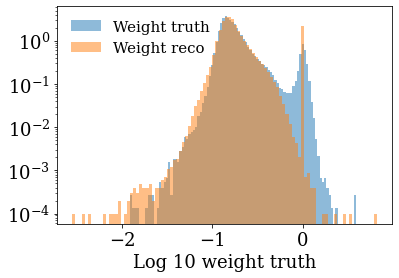

Iteration 0
113.22396850585938 0.00033983212779276073
1.8275316953659058 3.063865960939438e-06
 
Iteration 1
1.8040028810501099 0.0007643577409908175
1.4846361875534058 2.2679907488054596e-05
 
Iteration 2
4.58430814743042 0.002238265471532941
1.3707810640335083 0.0003432405646890402
 
Iteration 3
3.8521528244018555 0.0120994308963418
6.567196846008301 0.002822721842676401
 


In [88]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print ('Iteration %i'%i)
    print(max(weights[i, 1, :]), min(weights[i, 1, :]))    
    print(max(weights[i, 0, :]), min(weights[i, 0, :]))
    print(' ')

ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4


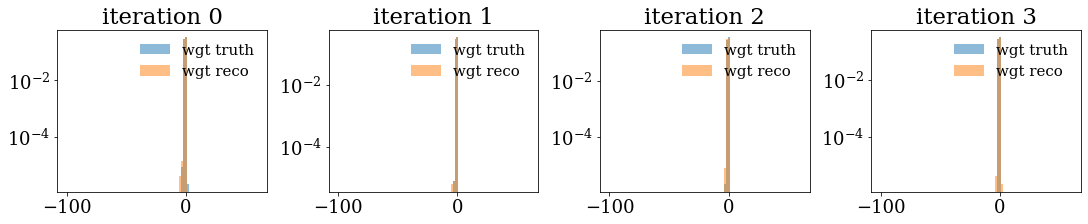

In [89]:
fig, ax = plt.subplots(1,
                           4,
                           figsize=(15, 3),
                           constrained_layout=True)
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    #bins = np.linspace(5, 50, 45)

    
    ax[i].hist(np.log10(weights[i, 1, :][~np.isnan(weights[i, 1, :])]),bins=100,range=(-100,60),**plot_style_2,label='wgt truth')
    ax[i].hist(np.log10(weights[i, 0, :][~np.isnan(weights[i, 0, :])]),bins=100,range=(-100,60),**plot_style_2, label='wgt reco') 
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_title('iteration %i'%i)

    #ax[i].xlabel('Log 10 weight truth')

## Incorporate weights into the dataframe

## MC at reco level reweighted vs data

The query is: pass_reco==1 
ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4


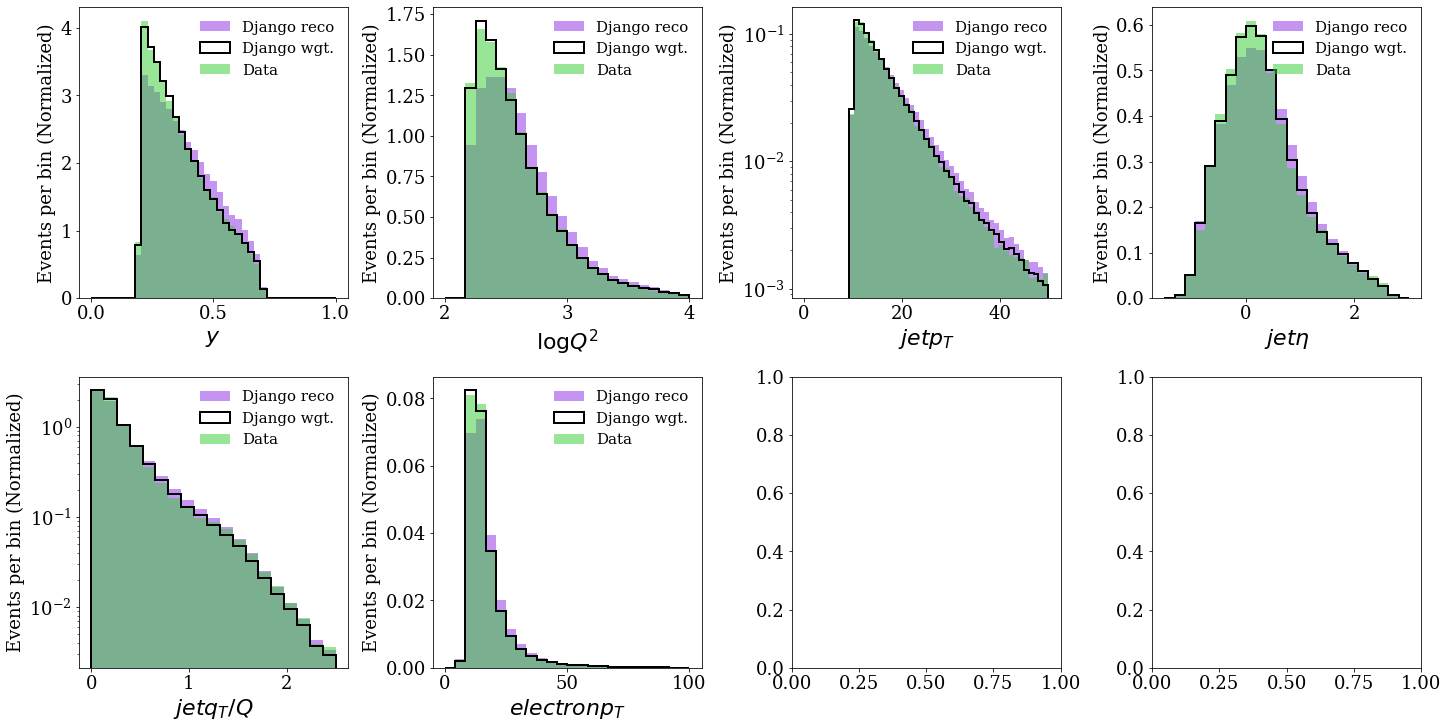

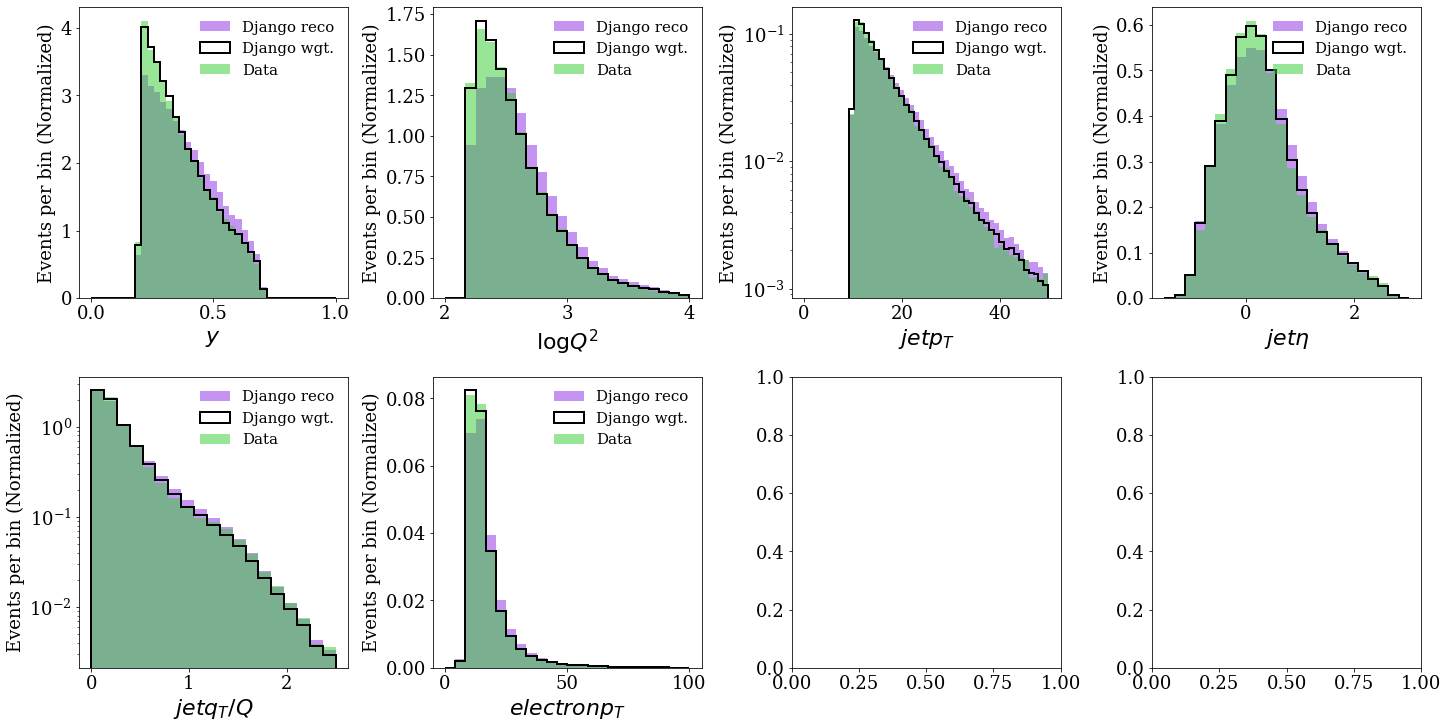

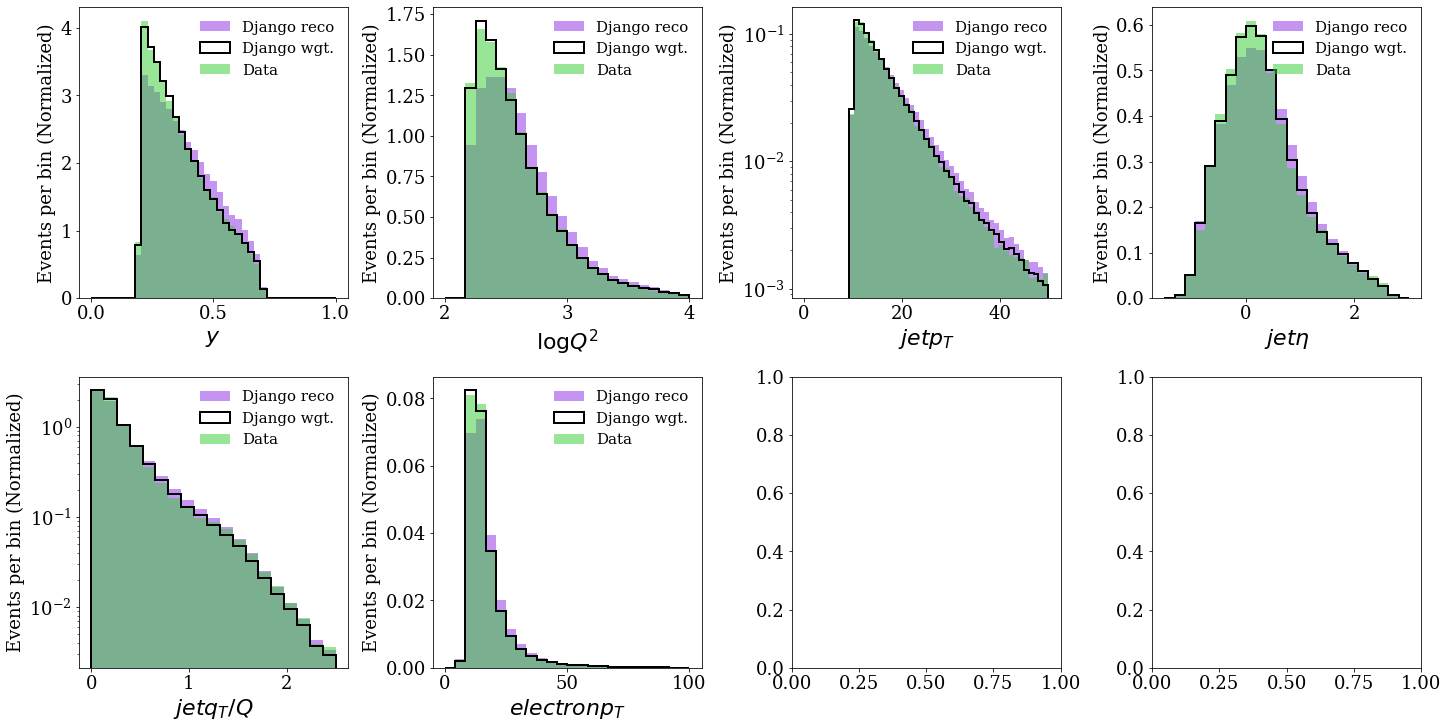

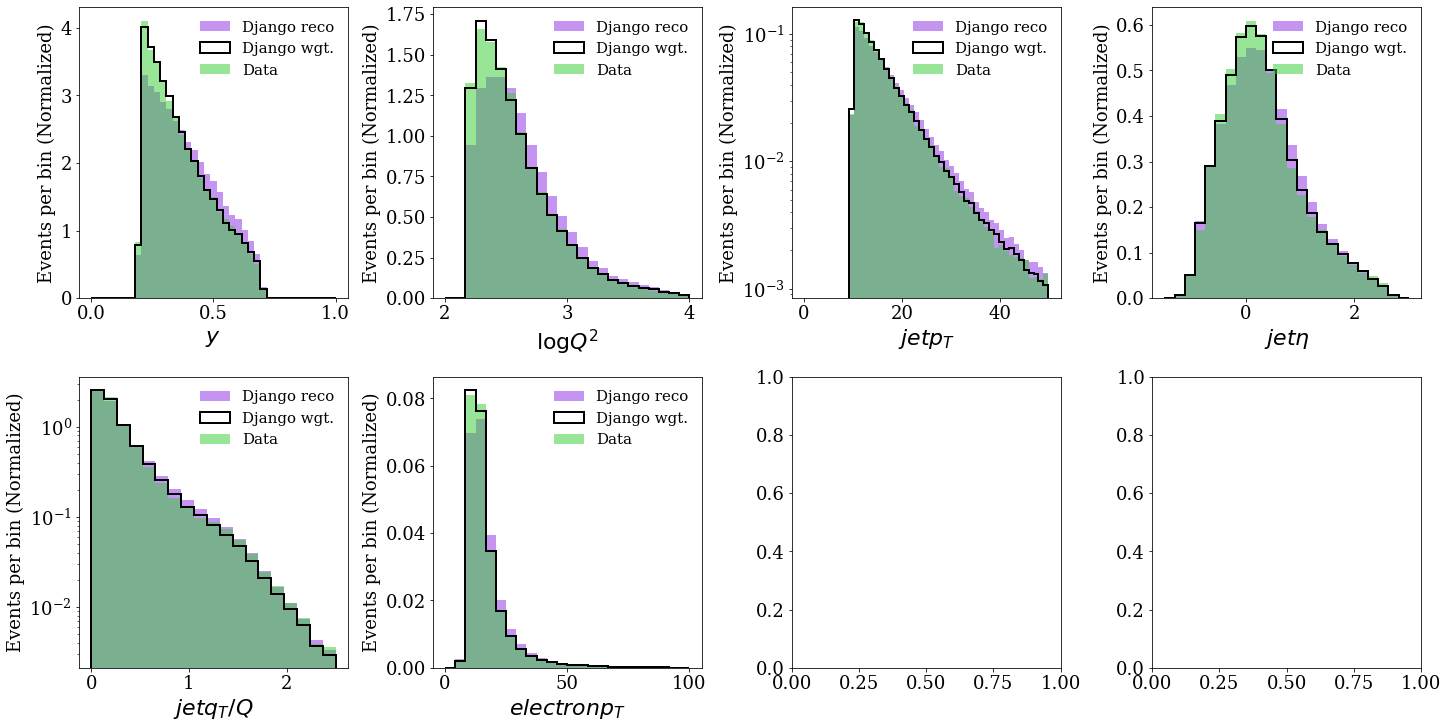

In [90]:



query = 'pass_reco==1 '
print('The query is:' , query)
label1 = r'Django reco'
label2 = r'Django wgt.'
label3 = r'Data'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,1].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$ jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['jet_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[0,2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet \eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['jet_eta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[0,3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,20)
    
    ax[1,0].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1,0].legend(frameon=False,loc='best')
    ax[1,0].set_yscale('log')

   
    bins = np.linspace(0,100,25)

    ax[1,1].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,1].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[1,1].legend(frameon=False,loc='best')
    
    #plt.tight_layout()


## Plot unfolded results

The query is: pass_reco==1
ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4


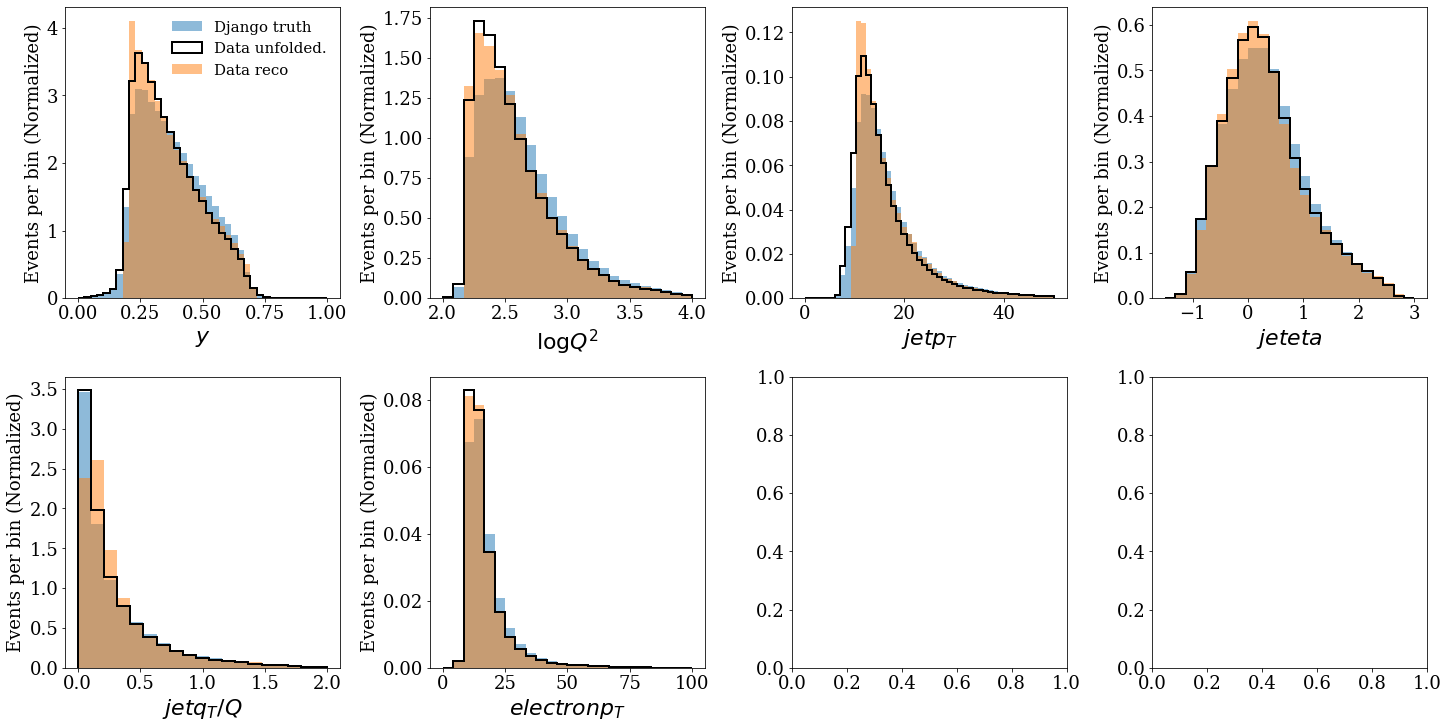

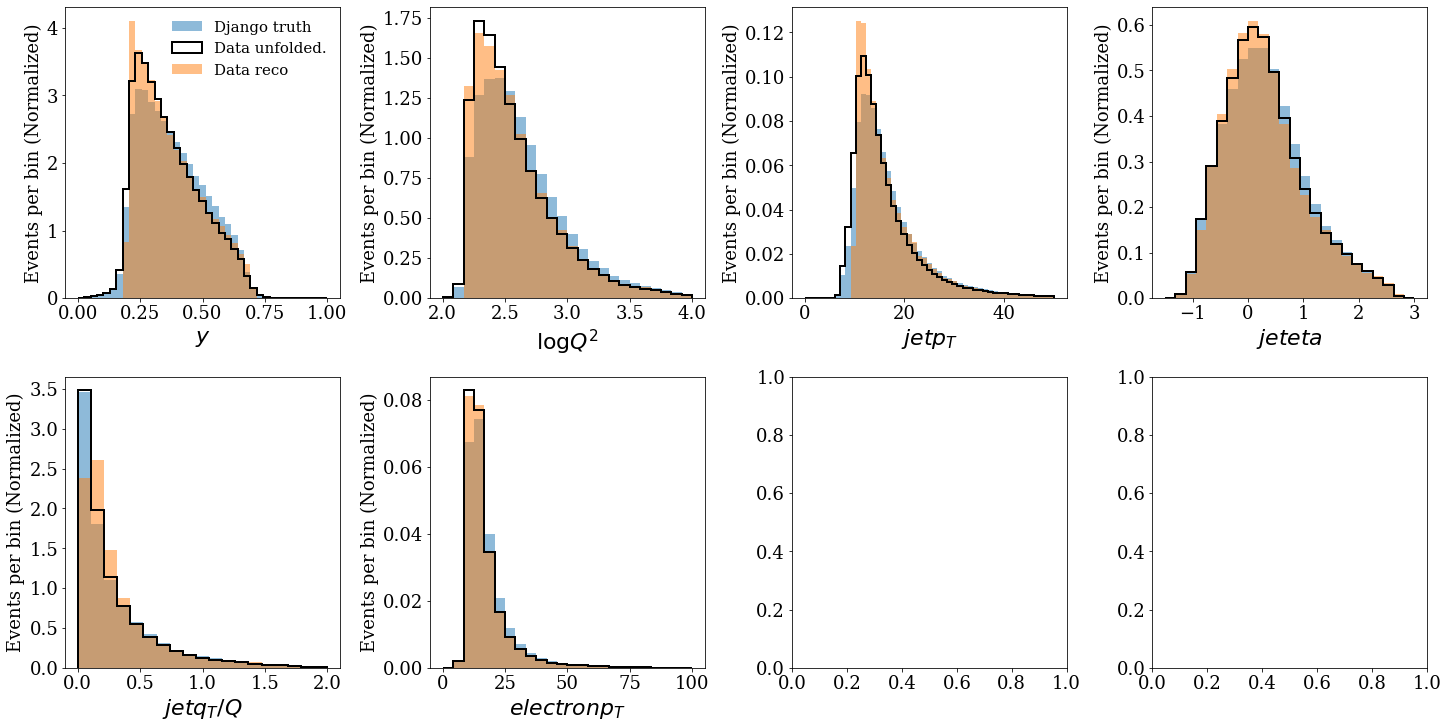

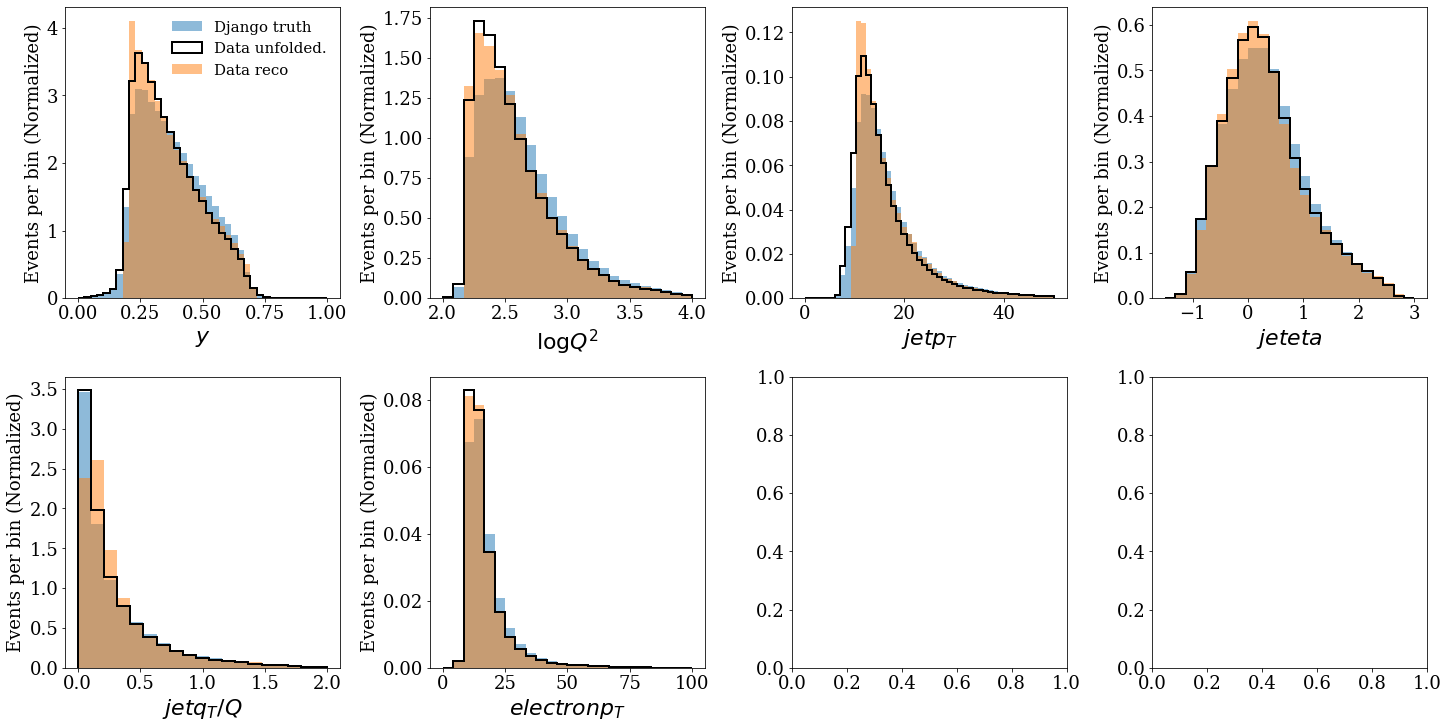

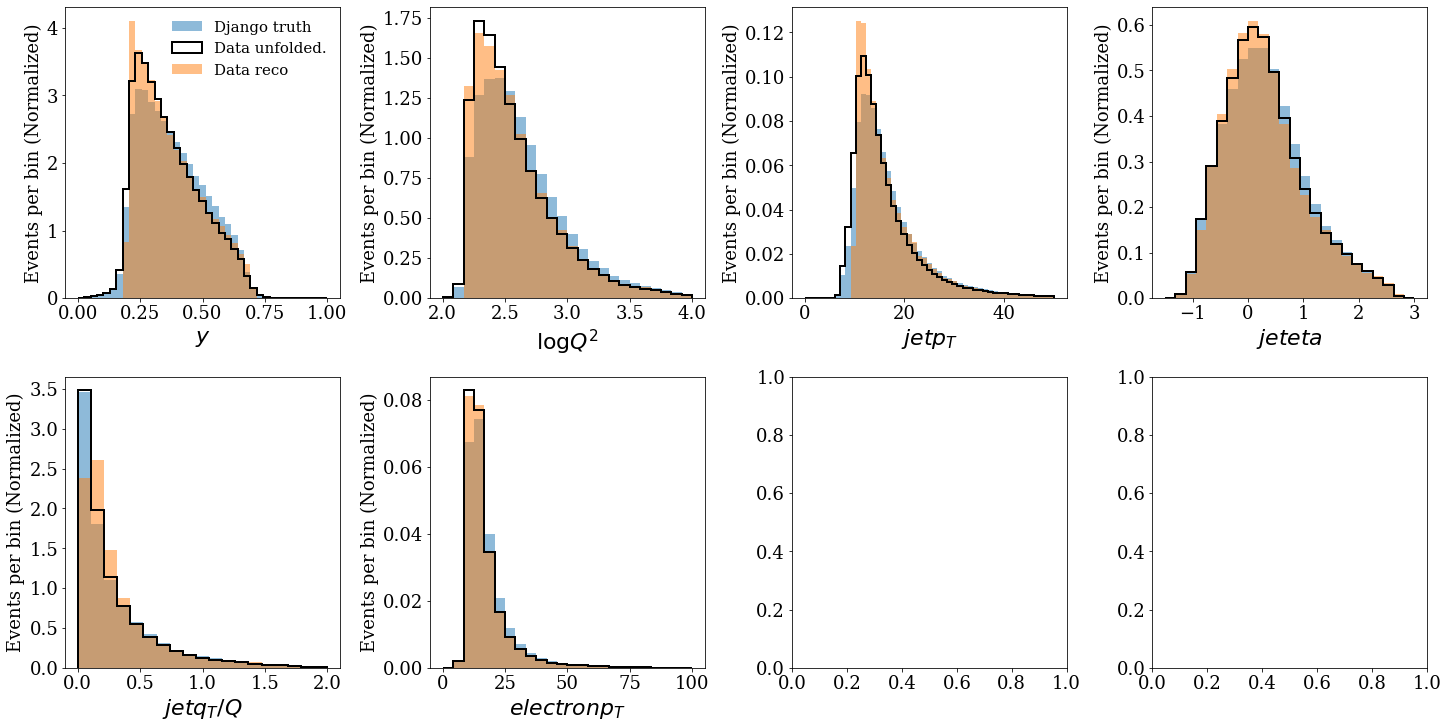

In [91]:
#event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
##track_selection = 'gen_track_pt>0.2'
#jet_selection    = 'gen_track_jetpt>15'
#query = 'pass_reco==1 and ' + event_selection + ' and ' + track_selection + ' and ' + jet_selection

query = 'pass_reco==1'
print('The query is:' , query)

label1 = r'Django truth'
label2 = r'Data unfolded.'
label3 = r'Data reco'

for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0,0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,0].legend(frameon=False)

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    

    
    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'], bins=bins, label=label1, **plot_style_2)
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    bins = np.linspace(0,2,20 )

    
    ax[1,0].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['genjet_qtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[1,0].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    
    #ax[1,1].set_yscale('log')

    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'], bins=bins, label=label1, **plot_style_2)
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    bins = np.linspace(0,100,25)

    ax[1,1].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[1,1].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    

## Plot data, and unfolded results and MC truth

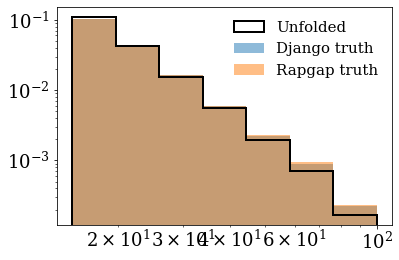

In [117]:
cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>15'
bins = np.logspace(np.log10(15),np.log10(100),8)
#plt.hist(data['jet_pt'],bins=bins,label='Data (reco)',**plot_style_2)
#num,x,_ = plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label='Rapgap Truth',**plot_style_2)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label = 'Django truth',**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label = 'Rapgap truth',**plot_style_2)


plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.show()

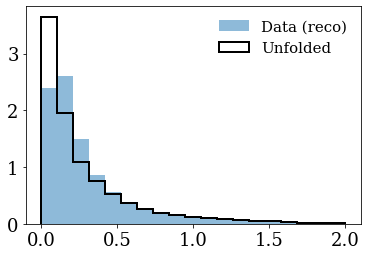

In [93]:
cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
bins = np.linspace(0,2,20)
plt.hist(data['jet_qtnorm'],bins=bins,label='Data (reco)',**plot_style_2)
#num,x,_ = plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label='Rapgap Truth',**plot_style_2)
den,x,_ = plt.hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)
#den,x,_ = plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label = 'Django truth',**plot_style_1)


plt.legend()
#plt.yscale('log')
#plt.xscale('log')

plt.show()

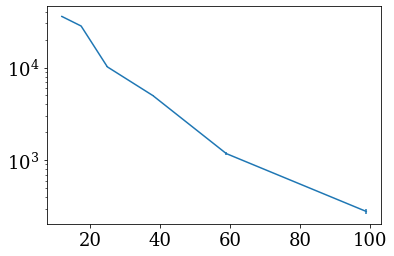

In [131]:
bins = np.array([10,14,21,29,47,71,127])
y, x  =np.histogram(data['jet_pt'],bins=bins)
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
erry = np.sqrt(y)
#erry = np.sqrt(y)/(xerr*2.0)
#y = y/(xerr*2.0)
plt.errorbar(x,y,yerr=erry)
plt.yscale('log')

In [104]:
#y, x  = np.histogram(df_jet['jet_pt'],bins=np.linspace(6,100,21))
cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>14'
bins = np.array([10,14,21,29,47,71,127])
y, x  = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/(xerr*2.0)
integral = np.sum(y)

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


6
6


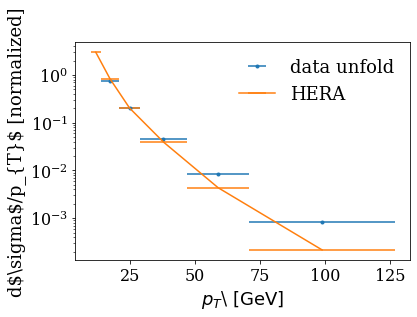

In [111]:


plt.errorbar(x,y=y/integral,  xerr = xerr, fmt='.',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'$p_{T}$\ $[\mathrm{GeV}]$',fontsize=18)
plt.ylabel(r'd$\sigma$/p_{T}$ [normalized]',fontsize=18)



#heray = np.array([2685, 1408,599.9,165.55,40.59,7.90, 0.873, 0.0433])
#heraxdo = np.array([6,8,10,14,21,29,47,71])
#heraxup = np.array([8,10,14,21,29,47,71,127])


heray = np.array([599.9,165.55,40.59,7.90, 0.873, 0.0433])
heraxdo = np.array([10,14,21,29,47,71])
heraxup = np.array([14,21,29,47,71,127])
heraerrx = (heraxup-heraxdo)/2.0
herax = (heraxup+heraxdo)/2.0

ratio = np.true_divide(0.005*heray,y/integral)


print(len(herax))
print(len(heray))
plt.errorbar(herax, 0.005*heray, xerr=heraerrx,label='HERA')
plt.legend(loc='best',frameon=False,fontsize=18)

plt.yscale('log')


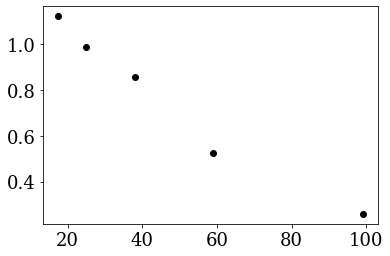

In [112]:
plt.plot(x,ratio,'o',color='black')

## Jet Spectrum

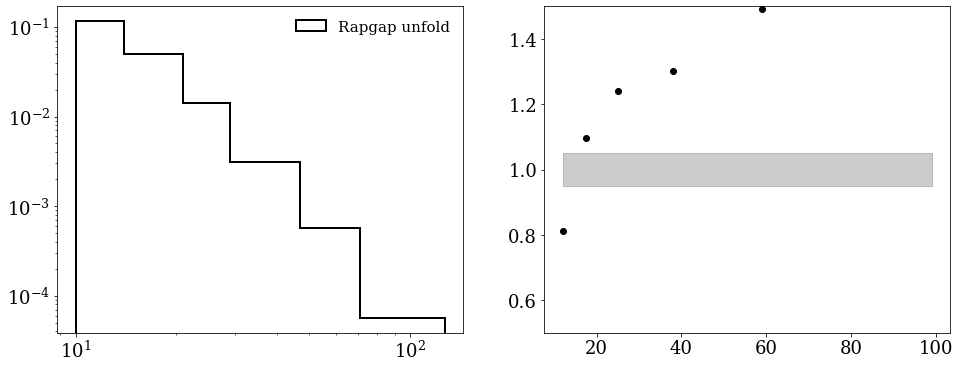

In [98]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
#bins = np.logspace(np.log10(15),np.log10(100),8)
bins = np.array([10,14,21,29,47,71,127])

#ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label='Django Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xscale('log')


ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

plt.show()

In [ ]:
## Jet pt spectrum

In [ ]:
bins = np.logspace(np.log10(0.01),np.log10(1),20)
fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f'%(edges[0],edges[1])
    cut = cut + ' and gen_track_jetpt>15'# and gen_track_jetqtnorm<0.3'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    axs[counter].hist(mc_cut.query(cut)['gen_track_jetqtnorm'],bins=bins,label='MC true',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['track_jetqtnorm'],weights=mc_cut.query(cut)['weight_reco'],bins=bins,alpha=0.9,density=True, label='MC wgt to data reco',color='black',lw=3,histtype='step')

    axs[counter].hist(mc_cut.query(cut)['gen_track_jetqtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_2)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))

    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


## Bootstrapping

In [ ]:
Q2_0_G = mc_cut['gen_logQ2']
Q2_0_S =mc_cut['logQ2']

y_0_G = mc_cut['gen_y']
y_0_S =mc_cut['y']

tau1b_0_G = mc_cut['gen_tau1b']
tau1b_0_S =mc_cut['tau1b']


In [ ]:
data_cut.head()

In [ ]:
K.clear_session()

In [ ]:
bootstraps = 20
iterations = 6 
nvariables = 3
weights = [] 

import timeit


for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)


In [ ]:
for i in range(30):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

In [ ]:
for i in range(50):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

In [ ]:
print(len(weights))

# for k in range(bootstraps):
#    for i in range(len(weights[k])):
        #print (weights[k].shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1:2, :][0]).shape)
print(myns[:,1])

In [ ]:
covariance_matrices = []
for it in range(6):
    myns = []
    #bins = np.logspace(np.log10(0.1),np.log10(1.0),8)
    #bins = np.logspace(np.log10(0.1),np.log10(np.pi),20)
    #bins = np.array([0.0, 2.05491515, 2.45354097, 2.63853135,
    #                 2.8145858,  2.98213597, 3.14159265])

    bins = np.logspace(0,1.2,100)
    #bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 

    #bins = np.logspace(np.log(1.0),np.log10(5.0),12) -1
    #bins = np.array([0., 0.1,0.2, 0.33994032, 0.55105852  ,1.07832585,2.0])
    #bins = np.flip( 2- np.logspace(np.log10(1),np.log10(2.0),5)) 

    #bins = np.append(bins,inf)

    for k in range(len(weights)-2):
        n,b,_ = plt.hist(tau1b_0_S,bins=bins,weights=weights[k][it, 1, :],alpha=0.3)
        myns+=[n]
        pass
    myns = np.array(myns)
    #print(myns)
    plt.xlabel('tau1b')

    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

    covariance_matrices.append(corr)
    #fig, ax = plt.subplots() 
    #im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
    #                         interpolation='none')
    #fig.colorbar(im,ax=ax)

print(covariance_matrices[0])
plt.show()

#print (len(myns))
#print (len(myns[0]))

In [ ]:
#bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 
#
#bins = np.array([0.0,1.37784484, 1.84030237, 2.05491515, 2.25916109, 2.45354097, 2.63853135,
# 2.8145858,  2.98213597, 3.14159265])
bins = np.linspace(0,1.0,100)#print(bins)
n,b,_ = plt.hist(tau1b_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)
#plt.yscale('log')
#plt.xscale('log')

In [ ]:
bins = np.logspace(np.log(1.0),np.log10(2.0),9) -1
print(bins)
n,b,_ = plt.hist(z_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)

In [ ]:
weights[75][it, 1, :] = 0

In [ ]:
for k in range(80):
    n,b,_ = plt.hist(qt_0_S,bins=bins,weights=weights[k][-1, 1, :],alpha=0.3)

In [ ]:
print(covariance_matrices[0])
print(covariance_matrices[1])
print(covariance_matrices[2])


In [ ]:
fig, ax = plt.subplots(2,3,figsize=(12,12)) 
minimo =-.40
maximo = 1.0
im = ax[0,0].imshow(covariance_matrices[0],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,1].imshow(covariance_matrices[1],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,2].imshow(covariance_matrices[2],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,0].imshow(covariance_matrices[3],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,1].imshow(covariance_matrices[4],cmap='RdBu', vmin=minimo, vmax =1.0,
                  interpolation='none')
im = ax[1,2].imshow(covariance_matrices[5],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')


ax[0,0].set_title('iteration #0')
ax[0,1].set_title('iteration #1')
ax[0,2].set_title('iteration #2')
ax[1,0].set_title('iteration #3')
ax[1,1].set_title('iteration #4')
ax[1,2].set_title('iteration #5')


plt.colorbar(im,ax=ax)
plt.show()

In [ ]:
covariance_matrices[4]

In [ ]:
from numpy.linalg import inv
x = [] 
rhos= []
for it in range(6): #iterations
    temp = []
    cov = np.matrix(covariance_matrices[it])
    inversecov = inv(cov)
    for i in range(cov.shape[0]):
         if(cov[i,i]*inversecov[i,i]!=0):
            temp.append( np.sqrt(1- 1.0/(cov[i,i]*inversecov[i,i])))
    rho_it = np.average(temp)
    rhos.append(rho_it)
    x.append(it)
    print (rho_it)
print (x)
print (rhos)

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,rhos,'-o')
plt.xlabel('Number of Multifold iterations',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [ ]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
fig, ax = plt.subplots() 
im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.show()

In [ ]:
print(corr)

In [ ]:

l = dphi_unknown_S
for i in range(10):
    ll = np.random.choice(l, size=l.shape, replace=False) 
    print(ll)
    print(len(ll))

In [ ]:
np.mean(ll)